In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from joblib import dump, load
from nilearn import plotting
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.stats import linregress
from sklearn.linear_model import Lasso

class BaseRegressor:
    def __init__(self,save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None,fit_params_train=None, models_params_train=None, name_model=None):             
        
        self.scaler = scaler if scaler is not None else StandardScaler()
        self.params = params if params is not None else {}
        self.params_space = params_space if params_space is not None else {}
        self.fit_params_search = fit_params_search if fit_params_search is not None else {}
        self.model_params_search = model_params_search if model_params_search is not None else {}
        self.fit_params_train = fit_params_train if fit_params_train is not None else {}
        self.model_params_train = models_params_train if models_params_train is not None else {}

        self.save_path = save_path
        self.model_ml = None
        self.name_model = name_model
        self.model = None
        self.opt_model = None
        self.explainer = None

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.residual_model = None


    def preprocess_data(self, X):        
        X_scaled = self.scaler.fit_transform(X)
        return pd.DataFrame(X_scaled, columns=X.columns)
    
    def set_data(self,X,y):        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=1)
           
    def search_best_model(self,  X=None, y=None, param_space_=None, n_iter_=10, n_jobs_=-1, scoring_metric='neg_mean_absolute_error', type_model=1):
       
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        if param_space_ is None:
            param_space = self.params_space
        else:
            param_space = param_space_

        n_splits = 10
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)       
        
        if type_model == 1:
            model = self.model_ml(**self.model_params_search)
        if type_model == 2:
            model = self.model_ml 

        self.opt_model = BayesSearchCV(
            estimator=model,
            search_spaces=param_space,
            #fit_params=self.fit_param,
            cv=kf,
            n_iter=n_iter_,
            scoring=scoring_metric,
            n_jobs=n_jobs_,
            random_state=42,
            verbose=1
        )                
        self.opt_model.fit(X, y, **self.fit_params_search)
        best_params_return = dict(self.opt_model.best_params_)  

        return self.opt_model, best_params_return
    
    
    def trainer(self, df_CN, df_patient=None, n_splits=10, n_iterations=20, params_=None, type_model=1, scaler=2):
    
        if params_ is None:
            params = self.params
        else:
            params = params_
        
        # Preparar el dataframe de controles
        X_CN = df_CN.iloc[:, :-2]  # Features
        y_CN = df_CN.iloc[:, -2]   # Labels (Age)
        ID_CN = df_CN.iloc[:, -1]  # IDs
        results_per_fold_CN_train = []
        results_per_fold_CN_test = []

        # Inicializar resultados
        results = {'model': [],
                   'mean_X_train_kf':[],
                   'std_X_train_kf':[],
                   'slope': [],
                   'intercept': [],
                   }
        
        results_labels_df_CN_train = pd.DataFrame(columns=['y_labels','y_pred','y_pred_corrected','GAP', 'GAP_corrected', 'ID-unique'])
        results_labels_df_CN_test = pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID-unique'])

        if df_patient is not None:
            results_per_fold_patient = [[] for _ in df_patient]
        else:
            results_per_fold_patient = []

        results_labels_patient = []

        # Inicializar resultados por fold para pacientes
        # Si lista_dfs no es None, crear dataframes para almacenar resultados de pacientes
        if df_patient is not None:
            for _ in df_patient:
                results_labels_patient.append(pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected','ID-unique']))
                #results_per_fold_pat.append({})  # Diccionario por cada grupo de pacientes
        
        # Bucle de iteraciones
        for i in range(n_iterations):
            # Crear validación cruzada para CN
            kf_CN = KFold(n_splits=n_splits, shuffle=True, random_state=i)
            kf_CN_splits = list(kf_CN.split(X_CN, y_CN))

            # Crear validación cruzada para cada dataframe de pacientes si lista_dfs no es None
            if df_patient is not None:
                kf_splits_list = [list(KFold(n_splits=n_splits, shuffle=True, random_state=i).split(df.iloc[:, :-2], df.iloc[:, -2])) for df in df_patient]

            for fold in range(n_splits):
                # Obtener índices de entrenamiento y prueba para CN
                train_index_CN, test_index_CN = kf_CN_splits[fold]
                X_train_kf_CN, X_test_kf_CN = X_CN.iloc[train_index_CN], X_CN.iloc[test_index_CN]
                y_train_kf_CN, y_test_kf_CN = y_CN.iloc[train_index_CN], y_CN.iloc[test_index_CN]
                id_train_kf_CN = ID_CN.iloc[train_index_CN]
                id_test_kf_CN = ID_CN.iloc[test_index_CN]

                # Escalar los datos de acuerdo con el parámetro scaler
                if scaler == 1:
                    # No escalar
                    X_train_kf_CN_scaled = X_train_kf_CN
                    X_test_kf_CN_scaled = X_test_kf_CN
                elif scaler == 2:
                    # Z-score scaling
                    mean_X_train_kf = X_train_kf_CN.mean()
                    std_X_train_kf = X_train_kf_CN.std()
                    X_train_kf_CN_scaled = (X_train_kf_CN - mean_X_train_kf) / std_X_train_kf
                    X_test_kf_CN_scaled = (X_test_kf_CN - mean_X_train_kf) / std_X_train_kf
                elif scaler == 3:
                    # MinMax scaling (manual)
                    min_X_train_kf = X_train_kf_CN.min()
                    max_X_train_kf = X_train_kf_CN.max()
                    X_train_kf_CN_scaled = (X_train_kf_CN - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)
                    X_test_kf_CN_scaled = (X_test_kf_CN - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)

                # Entrenar el modelo con CN
                if type_model == 1:
                    model = self.model_ml(**params, **self.model_params_train)
                if type_model == 2:
                    model = self.model_ml 
                model.fit(X_train_kf_CN_scaled, y_train_kf_CN)

                y_pred_CN_train = model.predict(X_train_kf_CN_scaled)
                gap_CN_train = y_pred_CN_train - y_train_kf_CN

                # Hacer predicciones para el conjunto de prueba de CN
                y_pred_CN_test = model.predict(X_test_kf_CN_scaled)
                gap_CN_test = y_pred_CN_test - y_test_kf_CN

                # Ajuste de GAP para CN
                slope, intercept, _, _, _ = linregress(y_train_kf_CN, gap_CN_train)
                corrected_gap_CN_train = gap_CN_train - (slope * y_train_kf_CN + intercept)
                corrected_gap_CN_test = gap_CN_test - (slope * y_test_kf_CN + intercept)
                y_pred_corrected_CN_test = y_pred_CN_test - (slope * y_test_kf_CN + intercept)
                y_pred_corrected_CN_train = y_pred_CN_train - (slope * y_train_kf_CN + intercept)

                # Guardar resultados de CN 
                temp_CN_df_test = pd.DataFrame({
                    'y_labels': y_test_kf_CN,
                    'y_pred': y_pred_CN_test,
                    'y_pred_corrected': y_pred_corrected_CN_test,
                    'GAP': gap_CN_test,
                    'GAP_corrected': corrected_gap_CN_test,
                    'ID-unique': id_test_kf_CN
                })
                temp_CN_df_train = pd.DataFrame({                    
                    'y_labels': y_train_kf_CN,
                    'y_pred': y_pred_CN_train,
                    'y_pred_corrected': y_pred_corrected_CN_train,
                    'GAP': gap_CN_train,
                    'GAP_corrected': corrected_gap_CN_train,
                    'ID-unique': id_train_kf_CN
                })

                results_labels_df_CN_train = pd.concat([results_labels_df_CN_train, temp_CN_df_train], ignore_index=True)
                results_per_fold_CN_train.append(temp_CN_df_train.copy())
                results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)
                results_per_fold_CN_test.append(temp_CN_df_test.copy())

                # Procesar cada dataframe de pacientes si lista_dfs no es None
                if df_patient is not None:
                    for j, df in enumerate(df_patient):
                        train_index_pat, test_index_pat = kf_splits_list[j][fold]
                        X_train_pat = df.iloc[train_index_pat, :-2]
                        X_test_pat = df.iloc[test_index_pat, :-2]
                        y_test_pat = df.iloc[test_index_pat, -2]
                        id_test_pat = df.iloc[test_index_pat, -1]

                        # Escalar usando los parámetros de CN
                        X_test_pat_scaled = (X_test_pat - mean_X_train_kf) / std_X_train_kf

                        # Predicciones para el grupo de pacientes
                        y_pred_pat_test = model.predict(X_test_pat_scaled)
                        gap_pat = y_pred_pat_test - y_test_pat

                        # Ajuste de GAP para los pacientes
                        corrected_gap_pat = gap_pat - (slope * y_test_pat + intercept)
                        y_pred_corrected_pat = y_pred_pat_test - (slope * y_test_pat + intercept)

                        # Guardar resultados para cada grupo de pacientes
                        temp_pat_df = pd.DataFrame({
                            'y_labels': y_test_pat,
                            'y_pred': y_pred_pat_test,
                            'y_pred_corrected': y_pred_corrected_pat,
                            'GAP': gap_pat,
                            'GAP_corrected': corrected_gap_pat,
                            'ID-unique': id_test_pat
                        })
                        results_labels_patient[j] = pd.concat([results_labels_patient[j], temp_pat_df], ignore_index=True)
                        results_per_fold_patient[j].append(temp_pat_df.copy())  # Guardar en la lista simple

                # Guardar el modelo entrenado
                results['model'].append(model)
                if scaler == 2:  # Z-score scaling
                    results['mean_X_train_kf'].append(mean_X_train_kf)
                    results['std_X_train_kf'].append(std_X_train_kf)
                elif scaler == 3:  # MinMax scaling
                    results['mean_X_train_kf'].append(min_X_train_kf)
                    results['std_X_train_kf'].append(max_X_train_kf)
                    
                results['slope'].append(slope)
                results['intercept'].append(intercept)

        return results_labels_df_CN_train, results_labels_df_CN_test, results_labels_patient, results, results_per_fold_CN_train,results_per_fold_CN_test, results_per_fold_patient


    def test(self):
        pass

    def avg_list(self, df_list):
        results_avg = []
        for df in df_list:            
            df_avg = df.groupby('ID-unique').agg({
                'y_labels': 'mean',
                'y_pred': 'mean',
                'y_pred_corrected': 'mean',
                'GAP': 'mean',
                'GAP_corrected': 'mean'
            }).reset_index()
            results_avg.append(df_avg)
        return results_avg

        
    def predicter(self, X_test=None):
        if X_test is None:
            X_test = self.X_test
        y_pred = self.model.predict(X_test)
        return y_pred   



    def regression_metrics(self, y_true, y_pred):
        """
        Calcula las métricas de regresión: MAE, MSE, RMSE y R2.
        """
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return mae, mse, rmse, r2

    def best_hyper(self, opt_model, num_best=10, num_max=400):
        """
        Obtiene los mejores hiperparámetros para las mejores puntuaciones de validación cruzada dentro de los primeros num_max resultados.
       
        """
        results = opt_model.cv_results_
        errors = results['mean_test_score'][:num_max]  # Considerar solo los primeros num_max resultados
        best_idx = np.argsort(errors)[-num_best:]  # Obtener los índices de las mejores puntuaciones
        best_hypers = []

        for idx in best_idx:
            hyper = {}
            for param, value in results['params'][idx].items():
                hyper[param] = value
            best_hypers.append(hyper)

        # Invertir el orden para que el mejor esté en el índice 0
        best_hypers = best_hypers[::-1]

        return best_hypers

    
    def calculate_simple_shap(self, X_train, X_test, model, random_seed=42):        
        try:
            self.explainer = shap.Explainer(model,X_train)
            shap_values = self.explainer.shap_values(X_test)
        except Exception as e:
            print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
            try:
                np.random.seed(random_seed)
                self.explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 10), num_jobs=-1)
                shap_values = self.explainer.shap_values(X_test)
            except Exception as kernel_e:
                print("Fallo al usar shap.KernelExplainer:", kernel_e)
                return None, None 

        shap_sum = np.abs(shap_values).sum(axis=0)
        # Crear un diccionario para almacenar la suma de SHAP por característica
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(X_test.columns)}

        # Ordenar las características por su suma de SHAP
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        # Imprimir el listado de importancia de características
        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:
            print(f"{feature}: {shap_sum}")
        
        return shap_values, shap_summary_sorted
    
    def calculate_multiple_shap(self, df_train, df_test, results_per_fold_train, results_per_fold_test, models_list, feature_col_range, iteration=20, kfolds_=10,  scaler=2, random_seed=42):
        shap_values_dict = {id_unique: [] for id_unique in df_test['ID-unique'].unique()}
        
        range_ = iteration*kfolds_
        
        for i in range(range_):

            # Train
            ID_train_fold = results_per_fold_train[i]['ID-unique']
            df_train_fold = df_train[df_train['ID-unique'].isin(ID_train_fold)]
            X_train_kf = df_train_fold.iloc[:, feature_col_range]  # Features
            y_train_kf = df_train_fold.iloc[:, -2]  # Labels

            # Test
            ID_test_fold = results_per_fold_test[i]['ID-unique']
            df_test_fold = df_test[df_test['ID-unique'].isin(ID_test_fold)]
            X_test_kf = df_test_fold.iloc[:, feature_col_range]  # Features
            y_test_kf = df_test_fold.iloc[:, -2]  # Labels

            if scaler == 1:
                # No escalar
                X_train_kf_scaled = X_train_kf
                X_test_kf_scaled = X_test_kf
            elif scaler == 2:
                # Z-score scaling
                mean_X_train_kf = X_train_kf.mean()
                std_X_train_kf = X_train_kf.std()
                X_train_kf_scaled = (X_train_kf - mean_X_train_kf) / std_X_train_kf
                X_test_kf_scaled = (X_test_kf - mean_X_train_kf) / std_X_train_kf
            elif scaler == 3:
                # MinMax scaling (manual)
                min_X_train_kf = X_train_kf.min()
                max_X_train_kf = X_train_kf.max()
                X_train_kf_scaled = (X_train_kf - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)
                X_test_kf_scaled = (X_test_kf - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)


            model_ = models_list[i]

            try:
                self.explainer = shap.Explainer(model_,X_train_kf_scaled)
                shap_values = self.explainer.shap_values(X_test_kf_scaled)
            except Exception as e:
                print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
                try:
                    np.random.seed(random_seed)
                    self.explainer = shap.KernelExplainer(model_.predict, shap.sample(X_train_kf_scaled, 10), num_jobs=-1)
                    shap_values = self.explainer.shap_values(X_test_kf_scaled)
                except Exception as kernel_e:
                    print("Fallo al usar shap.KernelExplainer:", kernel_e)
                    return None, None 

            # SHAP calculation
            #explainer = shap.Explainer(model_, X_train_kf_scaled)
            #shap_values = explainer.shap_values(X_test_kf_scaled)

            # Store SHAP values
            for idx, id_unique in enumerate(df_test_fold['ID-unique']):
                shap_values_dict[id_unique].append(shap_values[idx])

        # Average SHAP values
        shap_values_avg_dict = {id_unique: np.mean(values, axis=0) for id_unique, values in shap_values_dict.items()}

        # Prepare SHAP summary matrix
        shap_values_avg_matrix = [shap_values_avg_dict[id_unique] for id_unique in df_test['ID-unique'].unique()]
        shap_values_avg_array = np.array(shap_values_avg_matrix)

        feature_names = X_test_kf_scaled.columns.tolist()

        shap_values_df = pd.DataFrame(shap_values_avg_array, columns=feature_names)
        shap_values_df['ID-unique'] = df_test['ID-unique'].unique()
        shap_values_df.set_index('ID-unique', inplace=True)

        # SHAP summary
        shap_sum = np.abs(shap_values_avg_array).sum(axis=0)
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(feature_names)}
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        # Imprimir el listado de importancia de características
        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:
            print(f"{feature}: {shap_sum}")

        return shap_values_avg_array, shap_summary_sorted


    def shap_region(self, shap_summary_sorted, num_max=20):
        # Crear un diccionario para almacenar la suma de SHAP por región cerebral
        shap_por_region = {}

        # Recorrer la lista shap_summary_sorted
        for feature, shap_value in shap_summary_sorted[:num_max]:
            # Extraer la región cerebral (últimos dos textos separados por '_')
            region = feature.split('_')[-2] + '_' + feature.split('_')[-1]
            
            # Agregar la región cerebral al diccionario si no existe
            if region not in shap_por_region:
                shap_por_region[region] = 0.0
            
            # Sumar el valor SHAP al total de esa región cerebral
            shap_por_region[region] += shap_value
        
        max_value = max(shap_por_region.values())

        # Crear un diccionario para almacenar los valores normalizados
        resultado_normalizado = {}

        # Normalizar cada valor en el diccionario y almacenarlos en resultado_normalizado
        for region, suma_shap in shap_por_region.items():
            resultado_normalizado[region] = suma_shap / max_value

        # Ordenar shap_por_region y resultado_normalizado por valor descendente
        shap_por_region_sorted = {k: v for k, v in sorted(shap_por_region.items(), key=lambda item: item[1], reverse=True)}
        resultado_normalizado_sorted = {k: v for k, v in sorted(resultado_normalizado.items(), key=lambda item: item[1], reverse=True)}

        # Imprimir los valores normalizados ordenados
        for region, valor_normalizado in resultado_normalizado_sorted.items():
            print(f'{region}: {valor_normalizado:.6f}')

        return shap_por_region_sorted, resultado_normalizado_sorted

    

In [36]:
#C:\Users\felipe\OneDrive - Universidad Técnica Federico Santa María\Documentos

path=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/'
#import sys
#sys.path.append(path) 
path_=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model/'
import sys
sys.path.append(path_) 

In [49]:
from sklearn.linear_model import Lasso
#from base_regressor import BaseRegressor
from Plotter import Plotter
from skopt.space import Real, Categorical, Integer

class LassoRegressor(BaseRegressor):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="Lasso"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = Lasso
        if params is None:
            self.params = {
                'alpha': 0.2,
                'max_iter': 10000,
                #'tol': 0.001
            }
        if params_space is None:
            self.params_space = {
                'alpha': Real(0.001, 10.0, prior='log-uniform'),
                'max_iter': Integer(100, 1000),
                'tol': Real(1e-5, 1e-2, prior='log-uniform')
            }


In [23]:
# 72 Features
features = ['Alpha2_canon_EPP_HPC_left', 'Alpha2_canon_EPP_HPC_right', 'Alpha2_canon_EPP_PARIET_left', 'Alpha2_canon_EPP_PARIET_right', 'Alpha2_canon_EPP_OCC_left', 'Alpha2_canon_EPP_OCC_right', 'Alpha2_canon_RPD_HPC_left', 'Alpha2_canon_RPD_HPC_right', 'Alpha2_canon_RPD_CING_left', 'Alpha2_canon_RPD_CING_right', 'Alpha2_canon_RPD_PARIET_left', 'Alpha2_canon_RPD_PARIET_right', 'Alpha2_canon_RPD_OCC_left', 'Alpha2_canon_RPD_OCC_right', 'High_subj_spec_EPP_HPC_left', 'High_subj_spec_EPP_HPC_right', 'High_subj_spec_EPP_CING_left', 'High_subj_spec_EPP_CING_right', 'High_subj_spec_EPP_PARIET_left', 'High_subj_spec_EPP_PARIET_right', 'High_subj_spec_EPP_OCC_left', 'High_subj_spec_EPP_OCC_right', 'High_subj_spec_RPD_HPC_left', 'High_subj_spec_RPD_HPC_right', 'High_subj_spec_RPD_CING_left', 'High_subj_spec_RPD_CING_right', 'High_subj_spec_RPD_PARIET_left', 'High_subj_spec_RPD_PARIET_right', 'High_subj_spec_RPD_OCC_left', 'High_subj_spec_RPD_OCC_right', 'Low_subj_spec_EPP_HPC_left', 'Low_subj_spec_EPP_HPC_right', 'Low_subj_spec_EPP_CING_left', 'Low_subj_spec_EPP_CING_right', 'Low_subj_spec_EPP_PARIET_left', 'Low_subj_spec_EPP_PARIET_right', 'Low_subj_spec_EPP_OCC_left', 'Low_subj_spec_EPP_OCC_right', 'Low_subj_spec_RPD_HPC_left', 'Low_subj_spec_RPD_HPC_right', 'Low_subj_spec_RPD_CING_left', 'Low_subj_spec_RPD_CING_right', 'Low_subj_spec_RPD_PARIET_left', 'Low_subj_spec_RPD_PARIET_right', 'Low_subj_spec_RPD_OCC_left', 'Low_subj_spec_RPD_OCC_right', 'TF_ORB_left', 'TF_ORB_right', 'TF_IFG_left', 'TF_IFG_right', 'TF_MFG_left', 'TF_MFG_right', 'TF_SFG_left', 'TF_SFG_right', 'TF_HPC_left', 'TF_HPC_right', 'TF_INS_left', 'TF_INS_right', 'IAF_ORB_left', 'IAF_ORB_right', 'IAF_IFG_left', 'IAF_IFG_right', 'IAF_MFG_left', 'IAF_MFG_right', 'IAF_SFG_left', 'IAF_SFG_right', 'IAF_HPC_left', 'IAF_HPC_right', 'IAF_INS_left', 'IAF_INS_right', 'IAF_OCC_left', 'IAF_OCC_right']

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pickle


file_path_CN = f'{path}Brain_Aging/CN_freq.xlsx'
file_path_AD = f'{path}Brain_Aging/AD_freq.xlsx'
file_path_FTD = f'{path}Brain_Aging/FTD_freq.xlsx'
file_path_MCI = f'{path}Brain_Aging/MCI_freq.xlsx'
file_path_PD = f'{path}Brain_Aging/PD_freq.xlsx'

df_CN = pd.read_excel(file_path_CN)
df_AD = pd.read_excel(file_path_AD)
df_FTD = pd.read_excel(file_path_FTD)
df_MCI = pd.read_excel(file_path_MCI)
df_PD = pd.read_excel(file_path_PD)

df_CN_filtrado = df_CN[(df_CN['Age'] >=50) & (df_CN['Age'] <= 90)].reset_index(drop=True)
#SE ELIMINA CUBA DEL DATASET
#df_CN_filtrado = df_CN_filtrado[~df_CN_filtrado['Country_ID'].str.startswith('CUB')].reset_index(drop=True)

df_AD_filtrado = df_AD[(df_AD['Age'] >= 50) & (df_AD['Age'] <= 90)].reset_index(drop=True)
df_FTD_filtrado = df_FTD[(df_FTD['Age'] >= 50) & (df_FTD['Age'] <= 90)].reset_index(drop=True)
df_MCI_filtrado = df_MCI[(df_MCI['Age'] >= 50) & (df_MCI['Age'] <= 90)].reset_index(drop=True)
df_PD_filtrado = df_PD[(df_PD['Age'] >= 50) & (df_PD['Age'] <= 90)].reset_index(drop=True)


X_CN = df_CN_filtrado[features]
y_CN = df_CN_filtrado["Age"]
ID_CN = df_CN_filtrado["ID-unique"]

X_AD = df_AD_filtrado[features]
y_AD = df_AD_filtrado["Age"]
ID_AD = df_AD_filtrado["ID-unique"]

X_FTD = df_FTD_filtrado[features]
y_FTD = df_FTD_filtrado["Age"]
ID_FTD = df_FTD_filtrado["ID-unique"]

X_MCI = df_MCI_filtrado[features]
y_MCI = df_MCI_filtrado["Age"]
ID_MCI = df_MCI_filtrado["ID-unique"]

X_PD = df_PD_filtrado[features]
y_PD = df_PD_filtrado["Age"]
ID_PD = df_PD_filtrado["ID-unique"]

# 
X_combined = pd.concat([X_CN, X_AD, X_FTD, X_MCI, X_PD], axis=0).reset_index(drop=True)
#X_combined = pd.concat([X_CN, X_AD], axis=0).reset_index(drop=True)
scaler = StandardScaler()
scaler.fit(X_CN)

X_CN_scaled = scaler.transform(X_CN)
X_AD_scaled = scaler.transform(X_AD)
X_FTD_scaled = scaler.transform(X_FTD)
X_MCI_scaled = scaler.transform(X_MCI)
X_PD_scaled = scaler.transform(X_PD)

X_CN_scaled = pd.DataFrame(X_CN_scaled, columns=X_CN.columns)
X_AD_scaled = pd.DataFrame(X_AD_scaled, columns=X_AD.columns)
X_FTD_scaled = pd.DataFrame(X_FTD_scaled, columns=X_FTD.columns)
X_MCI_scaled = pd.DataFrame(X_MCI_scaled, columns=X_MCI.columns)
X_PD_scaled = pd.DataFrame(X_PD_scaled, columns=X_PD.columns)

##################################
df_concatenado_CN = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False)
df_concatenado_AD = pd.concat([X_AD, y_AD, ID_AD], axis=1, ignore_index=False)
df_concatenado_FTD = pd.concat([X_FTD, y_FTD, ID_FTD], axis=1, ignore_index=False)
df_concatenado_MCI = pd.concat([X_MCI, y_MCI, ID_MCI], axis=1, ignore_index=False)
df_concatenado_PD = pd.concat([X_PD, y_PD, ID_PD], axis=1, ignore_index=False)

df_patient = [df_concatenado_AD, df_concatenado_FTD, df_concatenado_MCI,df_concatenado_PD]

In [50]:
model = LassoRegressor()
Plotters = Plotter()

In [9]:
#'neg_mean_squared_error'
#'neg_root_mean_squared_error'
#'explained_variance'
#'r2'

opt_model, best_params = model.search_best_model (X=X_CN_scaled, y=y_CN, n_iter_=50, scoring_metric='r2')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

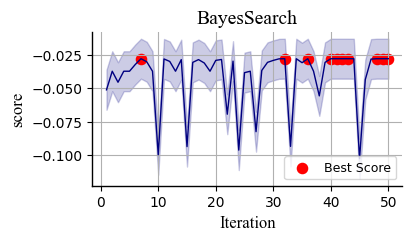

Top 1: Iteration 48, Score -0.02780506180555691
Top 2: Iteration 49, Score -0.02780954983821976
Top 3: Iteration 41, Score -0.027811612103926443
Top 4: Iteration 32, Score -0.02781171472852003
Top 5: Iteration 50, Score -0.027812306387002817
Top 6: Iteration 42, Score -0.027812384807490088
Top 7: Iteration 43, Score -0.027815366208878346
Top 8: Iteration 40, Score -0.027816714725264192
Top 9: Iteration 7, Score -0.027821057566171425
Top 10: Iteration 36, Score -0.027829719224466653


In [39]:
score = opt_model.cv_results_['mean_test_score'][:50]
Plotters.plot_iteration(y=score, title='BayesSearch', xlabel='Iteration', ylabel='score', legend_result=False, best_result=True, y_size=2, font='Times New Roman', weight='normal', mode=2, band_width=0.015)

In [40]:
best_params_ = model.best_hyper(num_best=10, opt_model=opt_model, num_max=50)
best_params_

[{'alpha': 0.292238810221719, 'max_iter': 907, 'tol': 1e-05},
 {'alpha': 0.292880436689753, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.2956630019705023, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.29317989205128836, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.29326034440276477, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.29678720489906185, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.2980079851918674, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.2940924191931304, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.29397976202716886, 'max_iter': 798, 'tol': 0.0001194177256833917},
 {'alpha': 0.2978782006358911, 'max_iter': 100, 'tol': 1e-05}]

In [41]:
results_labels_df_CN_train, results_labels_df_CN_test, results_labels_patient, results_model, results_per_fold_CN_train, results_per_fold_CN_test, results_per_fold_patient= model.trainer(df_CN=df_concatenado_CN,df_patient= df_patient, n_splits=10, n_iterations=20, params_=best_params_[0])

C:\Users\felipe\AppData\Local\Temp\ipykernel_1864\4020470439.py:207: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN_train = pd.concat([results_labels_df_CN_train, temp_CN_df_train], ignore_index=True)
C:\Users\felipe\AppData\Local\Temp\ipykernel_1864\4020470439.py:209: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)
C:\Users\felipe\AppData\Local\Temp\ipykernel_1864\4020470439.

In [43]:
results_labels_df_AD=results_labels_patient[0]
results_labels_df_FTD=results_labels_patient[1]
results_labels_df_MCI=results_labels_patient[2]
results_labels_df_PD=results_labels_patient[3]

results_labels_df_total = [results_labels_df_CN_train, results_labels_df_CN_test, results_labels_df_AD, results_labels_df_FTD,results_labels_df_MCI,results_labels_df_PD]

results_avg_list = model.avg_list(results_labels_df_total)

results_avg_CN_train = results_avg_list[0]
results_avg_CN_test = results_avg_list[1]
results_avg_AD = results_avg_list[2]
results_avg_FTD = results_avg_list[3]
results_avg_MCI = results_avg_list[4]
results_avg_PD = results_avg_list[5]

df_CN_seleccion = df_CN_filtrado[['ID-unique', 'Country_ID', 'Age', 'Sex', 'Educ', 'MMSE', 'HDI', 'GINI', 'ODQ']]
df_CN_combined = results_avg_CN_test.merge(df_CN_seleccion, on='ID-unique', how='left')

df_AD_seleccion = df_AD_filtrado[['ID-unique', 'Country_ID', 'Age', 'Sex', 'Educ', 'MMSE',  'GINI', 'ODQ']]
df_AD_combined = results_avg_AD.merge(df_AD_seleccion, on='ID-unique', how='left')

df_FTD_seleccion = df_FTD_filtrado[['ID-unique', 'Country_ID', 'Age', 'Sex', 'Educ', 'MMSE', 'GINI', 'ODQ']]
df_FTD_combined = results_avg_FTD.merge(df_FTD_seleccion, on='ID-unique', how='left')

df_MCI_seleccion = df_MCI_filtrado[['ID-unique', 'Country_ID', 'Age', 'Sex', 'Educ', 'MMSE',  'GINI', 'ODQ']]
df_MCI_combined = results_avg_MCI.merge(df_MCI_seleccion, on='ID-unique', how='left')

df_PD_seleccion = df_PD_filtrado[['ID-unique', 'Country_ID', 'Age', 'Sex', 'Educ', 'MMSE',  'GINI', 'ODQ']]
df_PD_combined = results_avg_PD.merge(df_PD_seleccion, on='ID-unique', how='left')


C:\Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model\Plotter.py:508: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Grupo', x='Error', data=df_errors, showfliers=False, palette=colores_personalizados,
C:\Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model\Plotter.py:526: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontname=font, fontsize=fontsize-2, fontweight=weight)


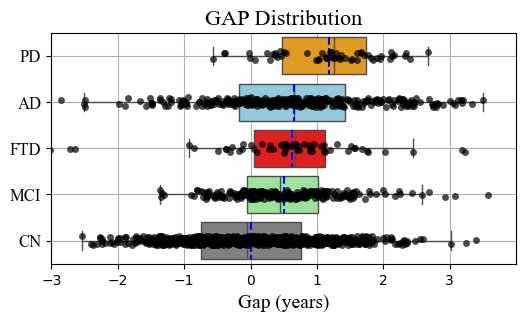

In [44]:
# Crear un DataFrame en formato largo para los errores
corrected_gap_AD = pd.to_numeric(results_avg_list[2]['GAP_corrected'])
corrected_gap_FTD = pd.to_numeric(results_avg_list[3]['GAP_corrected'])
corrected_gap_MCI = pd.to_numeric(results_avg_list[4]['GAP_corrected'])
corrected_gap_CN_test = pd.to_numeric(results_avg_list[1]['GAP_corrected'])
corrected_gap_PD = pd.to_numeric(results_avg_list[5]['GAP_corrected'])

data = {
    'Error': np.concatenate([corrected_gap_PD, corrected_gap_AD, corrected_gap_FTD, corrected_gap_MCI, corrected_gap_CN_test]),
    'Grupo': ['PD'] * len(corrected_gap_PD) + ['AD'] * len(corrected_gap_AD) + ['FTD'] * len(corrected_gap_FTD) + ['MCI'] * len(corrected_gap_MCI) + ['CN'] * len(corrected_gap_CN_test)
}

df_errors = pd.DataFrame(data)

# Definir la paleta de colores personalizada
colores_personalizados = {
    'AD': 'skyblue',
    'FTD': 'red',
    'MCI': 'lightgreen',
    'PD': 'orange',
    'CN': 'gray'
}

Plotters.plot_gap_distribution(df_errors, colores_personalizados,x_size=6, y_size=3,font='Times New Roman', weight='normal', xlabel='Gap (years)', x_limits=(-3, 4),fontsize=14)

CN - Pendiente: 0.009218071919656573, Intercepto: 65.47332529553327
AD - Pendiente: 0.039425069624879815, Intercepto: 64.0219913999623
FTD - Pendiente: -0.01860930552609317, Intercepto: 68.09767829348115
MCI - Pendiente: 0.0041749314128698535, Intercepto: 66.33008749179716
PD - Pendiente: 0.0027245906297843655, Intercepto: 67.04116951017643


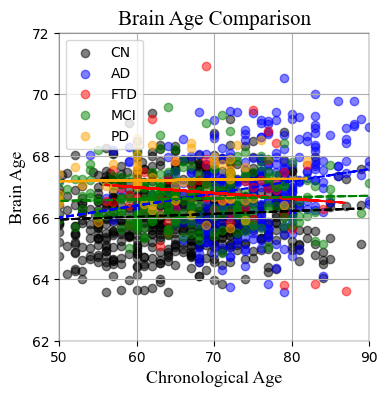

In [45]:
results_avg_CN_ = results_avg_list[1][['y_labels', 'y_pred']].copy()
results_avg_AD_ = results_avg_list[2][['y_labels', 'y_pred']].copy()
results_avg_FTD_     = results_avg_list[3][['y_labels', 'y_pred']].copy()
results_avg_MCI_ = results_avg_list[4][['y_labels', 'y_pred']].copy()
results_avg_PD_ = results_avg_list[5][['y_labels', 'y_pred']].copy()

df_list = [results_avg_CN_, results_avg_AD_, results_avg_FTD_, results_avg_MCI_, results_avg_PD_]
colors = {'CN': 'black', 'AD': 'blue', 'FTD': 'red', 'MCI': 'green', 'PD': 'orange'}
labels = ['CN', 'AD', 'FTD', 'MCI', 'PD']
Plotters.plot_regression_diagnosis(df_list=df_list, colors=colors, title='Brain Age Comparison',labels=labels,x_ticks_step=10,y_ticks_step=2,x_min_limit=50,y_min_limit=62,x_max_limit=90,y_max_limit=72,line_ideal=False, alpha=0.5, xlabel='Chronological Age',ylabel='Brain Age',  font='Times New Roman', weight='normal', x_size=4,y_size=4, legend=True, fontsize=13, mode=3,xticks =1,yticks=1)

In [51]:
slice(None, -2)

slice(None, -2, None)

In [53]:
shap_values_CN, shap_summary_sorted_CN = model.calculate_multiple_shap(
    df_concatenado_CN, df_concatenado_CN, results_per_fold_CN_train, results_per_fold_CN_test, results_model['model'], slice(None, -2)
)

shap_values_AD, shap_summary_sorted_AD = model.calculate_multiple_shap(
    df_concatenado_CN, df_concatenado_AD, results_per_fold_CN_train, results_per_fold_patient[0], results_model['model'], slice(None, -2)
)

shap_values_FTD, shap_summary_sorted_FTD = model.calculate_multiple_shap(
    df_concatenado_CN, df_concatenado_FTD, results_per_fold_CN_train, results_per_fold_patient[1], results_model['model'], slice(None, -2)
)

shap_values_MCI, shap_summary_sorted_MCI = model.calculate_multiple_shap(
    df_concatenado_CN, df_concatenado_MCI, results_per_fold_CN_train, results_per_fold_patient[2], results_model['model'], slice(None, -2)
)

shap_values_PD, shap_summary_sorted_PD = model.calculate_multiple_shap(
    df_concatenado_CN, df_concatenado_PD, results_per_fold_CN_train, results_per_fold_patient[3], results_model['model'], slice(None, -2)
)


Importancia de características basada en suma de valores SHAP:
Low_subj_spec_RPD_HPC_right: 287.2999936043567
Alpha2_canon_EPP_PARIET_left: 176.89660603656773
Low_subj_spec_EPP_OCC_right: 148.71330281498564
Low_subj_spec_RPD_HPC_left: 103.97493618455506
IAF_ORB_left: 100.80324199060527
IAF_INS_right: 88.66740479801305
IAF_HPC_left: 80.69223485095212
TF_IFG_right: 59.18118930399073
Low_subj_spec_EPP_HPC_left: 56.655084021257785
TF_INS_left: 36.797939304637055
Low_subj_spec_RPD_PARIET_right: 32.708485344008565
Alpha2_canon_EPP_PARIET_right: 26.320060183800326
TF_HPC_left: 23.159865447954857
IAF_INS_left: 22.889449817909203
Low_subj_spec_EPP_OCC_left: 18.641849717250977
IAF_HPC_right: 17.17068187292132
High_subj_spec_EPP_HPC_left: 11.040242093886187
IAF_OCC_left: 7.730890760724439
Low_subj_spec_EPP_CING_left: 7.209683333814739
Alpha2_canon_RPD_PARIET_left: 7.207357925306848
TF_SFG_right: 5.372750893934123
TF_ORB_right: 4.595239484657137
Low_subj_spec_EPP_CING_right: 3.8215431566103333
Hig

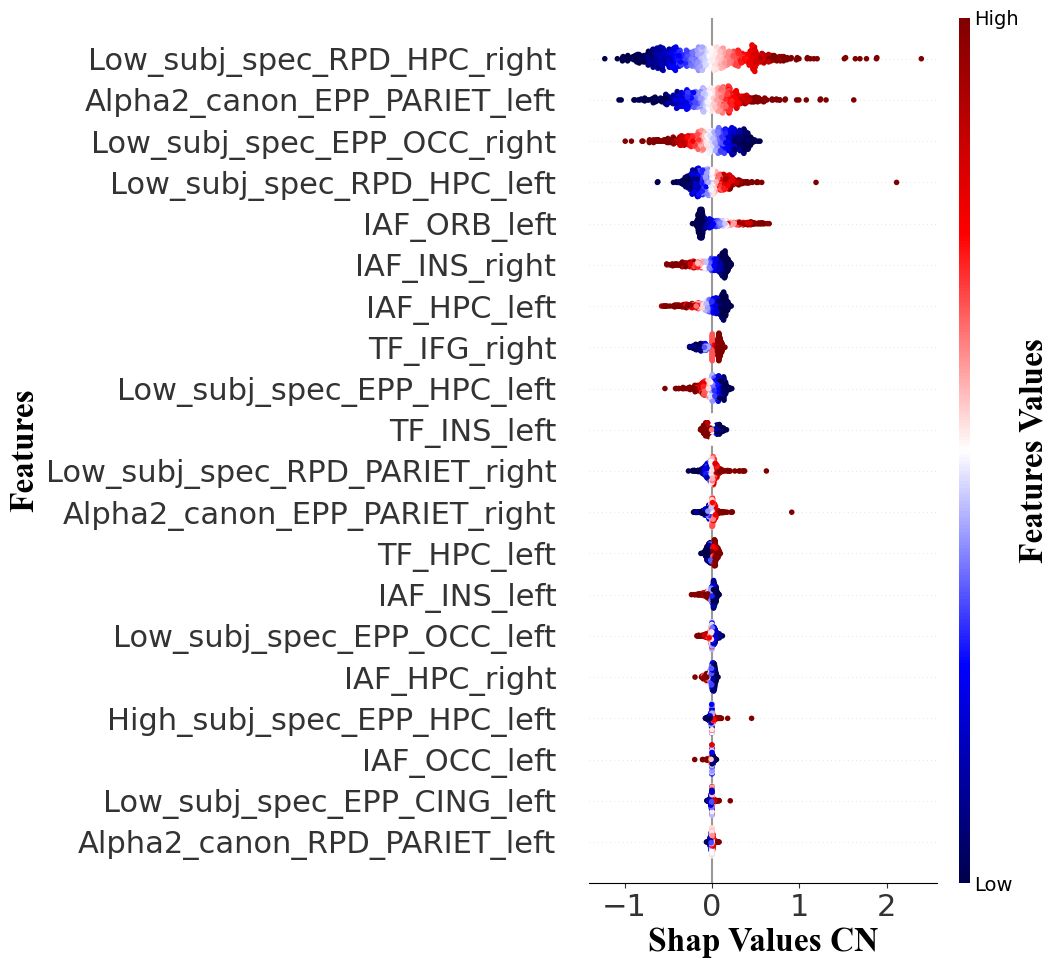

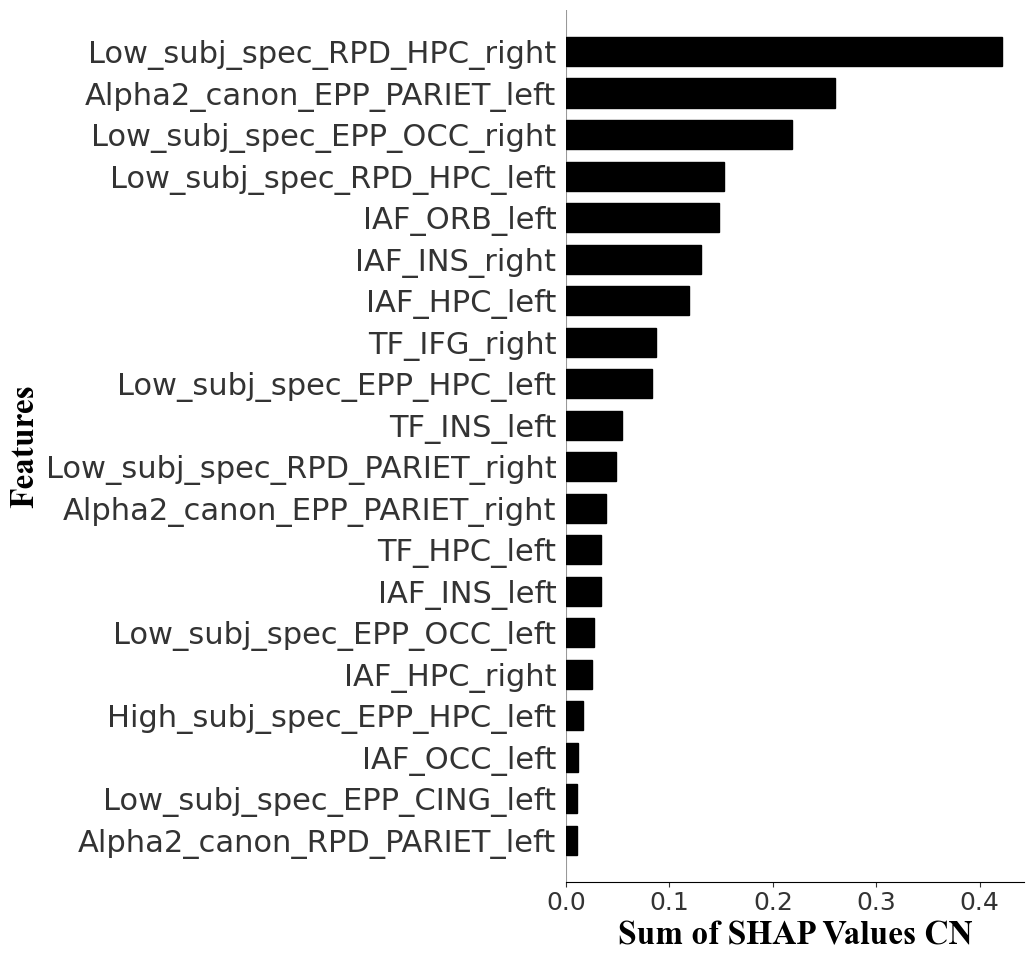

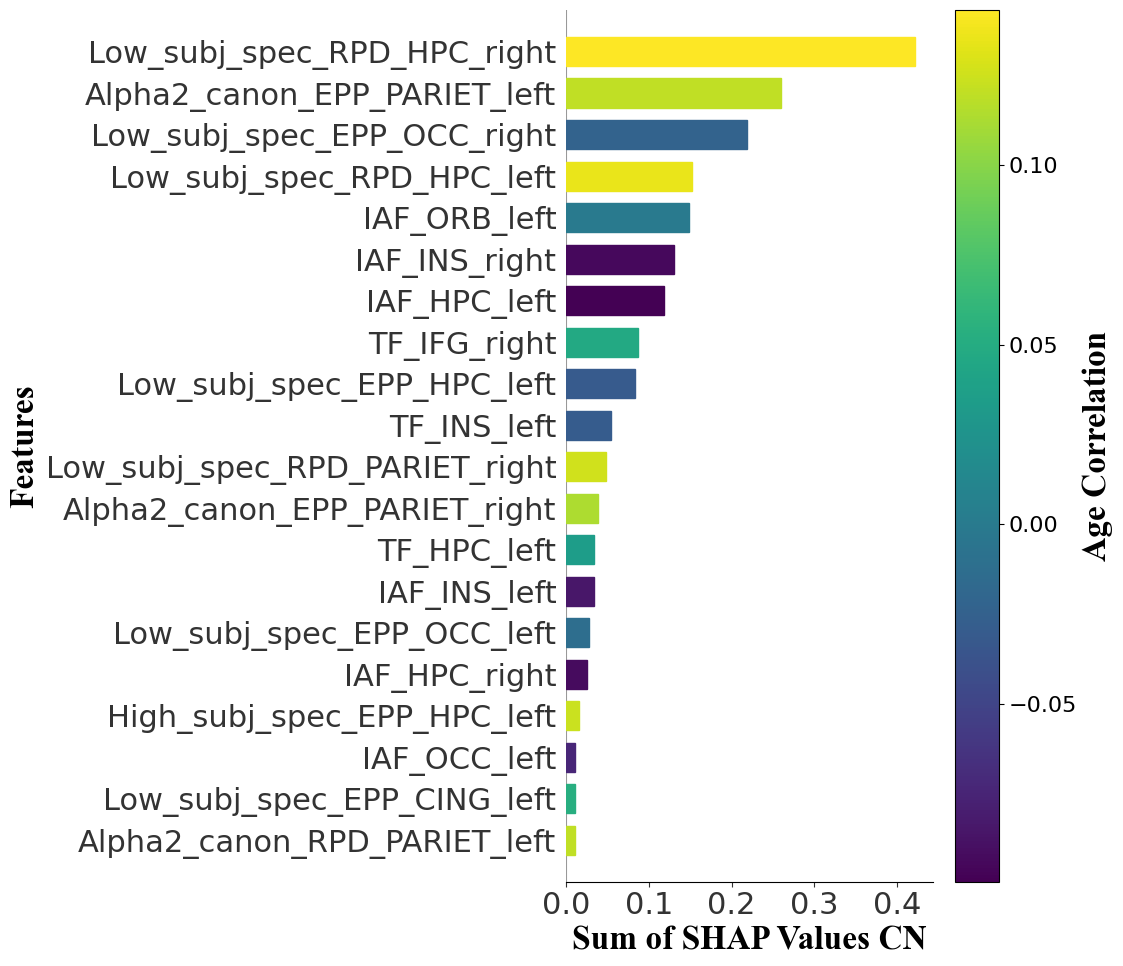

In [54]:
Plotters.plot_feature_importance(shap_values=shap_values_CN,X_test=X_CN,y_test=y_CN, font= "Times New Roman", fontsize=24, xlabel1='Shap Values CN', xlabel2='Sum of SHAP Values CN',ylabel='Features', ylabel1='Features Values', ylabel2='Age Correlation')